# Previsão de Doenças Cardiovasculares

O objetivo é prever a variável binária : ** Heart Disease Status ** .Sendo este, um problema de classificação, ideal para treinar modelos como Random Forest, Decision Tree ...

#### Dataset

O dataset elegido para este estudo foi **"Heart Disease Data for Health Research**, que contém características (features) que são cruciais no mundo real para o estudo de doeças cardiovascular, como:

> - Feature 1 - explicar
>
> - Feature 2 - explicar
>
> - Feature 3 - explicar
>

Podem ainda, ser considerados os seguintes atributos de risco: `feature 1, feature 2 `

### Necessário

> **Dataset** nome.csv
>
> Obtido em :  `https://www.kaggle.com/datasets/oktayrdeki/heart-disease`


**Questões adicionais**

-Quais variáveis mais influenciam o risco? (feature importance)

-Modelos mais simples funcionam tão bem quanto modelos complexos?

-Podemos otimizar o recall sem perder muita precisão?

-Existe algum grupo com maior risco (ex.: idade, sexo)?
        

In [3]:
!pip install mlxtend
!pip install catboost
!pip install xgboost

In [4]:

import pandas as pd
import numpy as np

from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, confusion_matrix, classification_report, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

import seaborn as sns
import xgboost as xgb
import joblib

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 120


In [22]:
# import dataset
dataset_path = "./heart_disease.csv"
df = pd.read_csv(dataset_path)

## Regras de formatação do header do dataset
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('...', '')

display(df.head())

# Debugg Extra
#print(df.columns)
#print(df.shape)
print(df.info()) 

,age,gender,blood_pressure,cholesterol_level,exercise_habits,smoking,family_heart_disease,diabetes,bmi,high_blood_pressure,...,high_ldl_cholesterol,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,fasting_blood_sugar,crp_level,homocysteine_level,heart_disease_status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   9971 non-null   float64
 1   gender                9981 non-null   object 
 2   blood_pressure        9981 non-null   float64
 3   cholesterol_level     9970 non-null   float64
 4   exercise_habits       9975 non-null   object 
 5   smoking               9975 non-null   object 
 6   family_heart_disease  9979 non-null   object 
 7   diabetes              9970 non-null   object 
 8   bmi                   9978 non-null   float64
 9   high_blood_pressure   9974 non-null   object 
 10  low_hdl_cholesterol   9975 non-null   object 
 11  high_ldl_cholesterol  9974 non-null   object 
 12  alcohol_consumption   7414 non-null   object 
 13  stress_level          9978 non-null   object 
 14  sleep_hours           9975 non-null   float64
 15  sugar_consumption   

## EDA - Análise Exploratória de Dados
De forma a entender a estrutura, qualidade e as relações subjacentes do dataset, e tendo em conta que o DataFrame é tanto numérico padronizado e categórico, a análise exploratória deve ser focada em duas áreas principais, a Visão Geral e Análise Bivariada.


In [24]:
column_execption = ["alcohol_consumption", "stress_level", "sugar_consumption", "exercise_habits"]

numeric_cols = [
    "age", "blood_pressure", "cholesterol_level", "bmi", "sleep_hours", 
    "triglyceride_level", "fasting_blood_sugar", "crp_level", "homocysteine_level"
]

print("Informações do DataFrame:\n")
display(df.info())

print("\nValores Ausentes por Coluna:\n")
display(df.isnull().sum().sort_values(ascending=False).head())

status_counts = df["heart_disease_status"].value_counts()
display(status_counts)

# Verificação rápida se existem colunas com valores Na

missing_values = df.isna().sum()
print("Valores em falta:", missing_values)
#Converter colunas numéricas
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nValores Ausentes após a conversão forçada:")
display(df[numeric_cols].isna().sum())

Informações do DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   9971 non-null   float64
 1   gender                9981 non-null   object 
 2   blood_pressure        9981 non-null   float64
 3   cholesterol_level     9970 non-null   float64
 4   exercise_habits       9975 non-null   object 
 5   smoking               9975 non-null   object 
 6   family_heart_disease  9979 non-null   object 
 7   diabetes              9970 non-null   object 
 8   bmi                   9978 non-null   float64
 9   high_blood_pressure   9974 non-null   object 
 10  low_hdl_cholesterol   9975 non-null   object 
 11  high_ldl_cholesterol  9974 non-null   object 
 12  alcohol_consumption   7414 non-null   object 
 13  stress_level          9978 non-null   object 
 14  sleep_hours           9975 non-null   float6

None


Valores Ausentes por Coluna:



alcohol_consumption    2586
cholesterol_level        30
sugar_consumption        30
diabetes                 30
age                      29
dtype: int64

heart_disease_status
No     8000
Yes    2000
Name: count, dtype: int64

Valores em falta: age                       29
gender                    19
blood_pressure            19
cholesterol_level         30
exercise_habits           25
smoking                   25
family_heart_disease      21
diabetes                  30
bmi                       22
high_blood_pressure       26
low_hdl_cholesterol       25
high_ldl_cholesterol      26
alcohol_consumption     2586
stress_level              22
sleep_hours               25
sugar_consumption         30
triglyceride_level        26
fasting_blood_sugar       22
crp_level                 26
homocysteine_level        20
heart_disease_status       0
dtype: int64

Valores Ausentes após a conversão forçada:


age                    29
blood_pressure         19
cholesterol_level      30
bmi                    22
sleep_hours            25
triglyceride_level     26
fasting_blood_sugar    22
crp_level              26
homocysteine_level     20
dtype: int64

#### Verificação dos Valores None do alchool consunption

O valor None neste dataset não representa uma valor nulo, mas representa "nenhum consumo" para a variável alcholl consumption do dataset. 

Como a lib do pandas transforma None como NaN e considera estes como nulos é necessário criar uma execeção para esta coluna para ela nao ser padronizada.

In [26]:
print("\nValores Ausentes após a conversão forçada (Esses eram os valores de texto/lixo):")
df_original_len = len(df)
df = df.dropna(subset=numeric_cols)

print(f"\nNovo número de linhas após limpar o lixo numérico: {len(df)}")
print(f"Linhas removidas nesta etapa: {df_original_len - len(df)}")

print("Contagem de NaNs (padronizado pelo pandas):", df['alcohol_consumption'].isna().sum(0)) 
df['heart_disease_num'] = df['heart_disease_status'].map({'No': 0, 'Yes': 1})

numeric_cols_for_corr = [
    "blood_pressure", "cholesterol_level", "bmi", "sleep_hours", 
    "triglyceride_level", "fasting_blood_sugar", "crp_level", "homocysteine_level",
    "heart_disease_num"
];

for col in column_execption:
    df[col] = df[col].fillna("None")

# Limpeza
cols_to_dropna_on = [col for col in df.columns if col not in column_execption]
df = df.dropna(subset=cols_to_dropna_on)

print("\nNovo tamanho final do dataset após drop geral (exceto a coluna exceção):", len(df))


Valores Ausentes após a conversão forçada (Esses eram os valores de texto/lixo):

Novo número de linhas após limpar o lixo numérico: 9781
Linhas removidas nesta etapa: 219
Contagem de NaNs (padronizado pelo pandas): 2529

Novo tamanho final do dataset após drop geral (exceto a coluna exceção): 9609


## Análise Gráfica do Dataset

Para confirmar a validade e o insight das Regras de Associação iremos apresentar um Count Plot do **Heart Disease Status** de forma a revelar o balanceamento da variável alvo, prevenindo modelos enviesados.

**Melhorar**

Escolher as classes pelos metodos estatisco

n = n~de dados



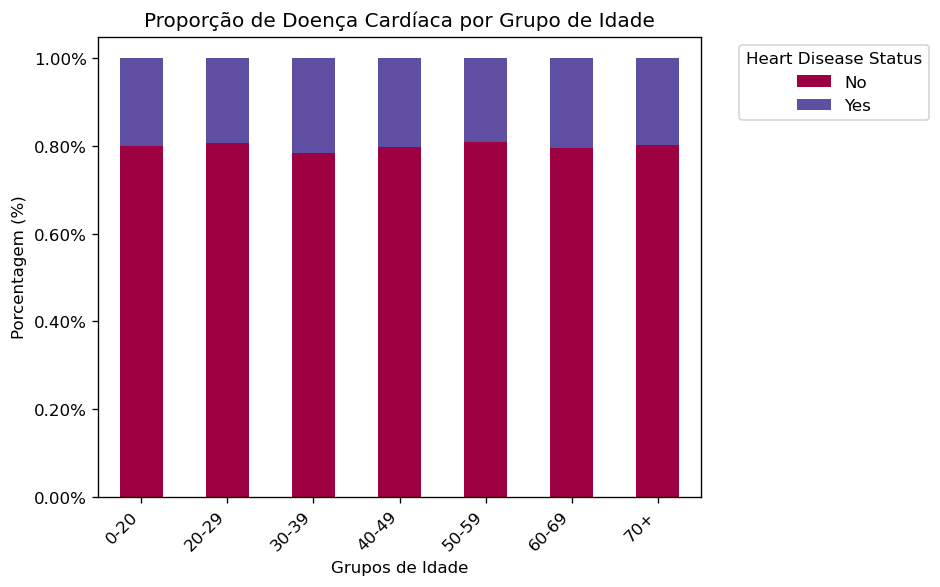

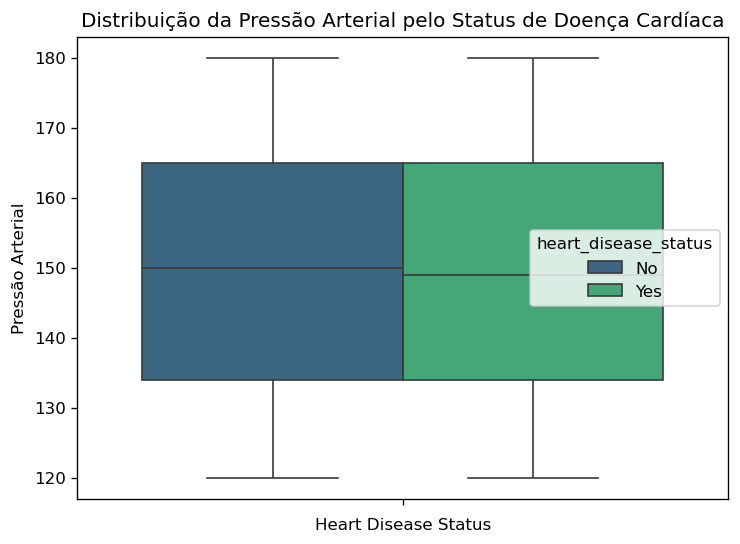

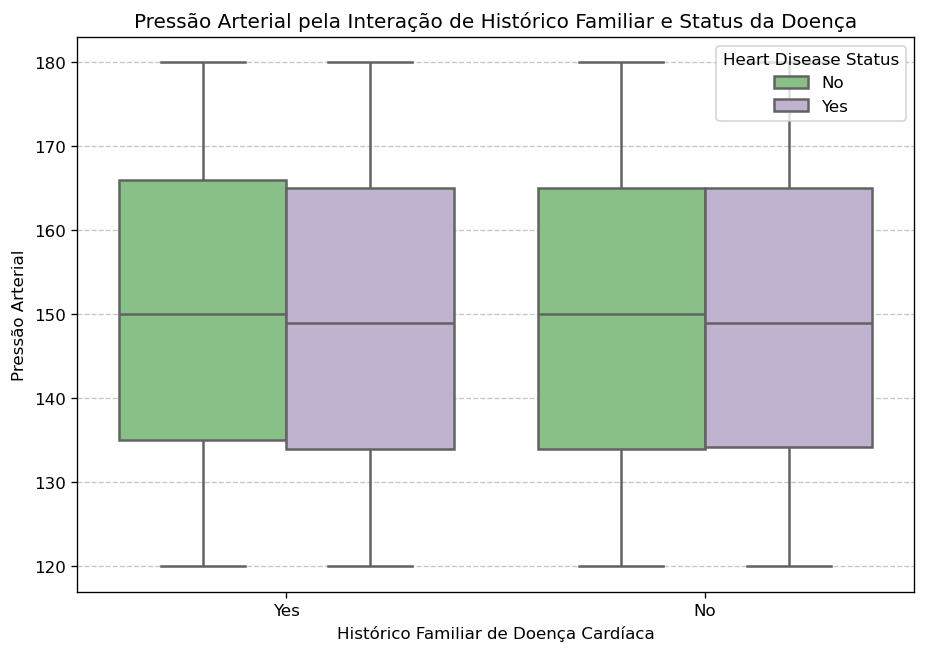

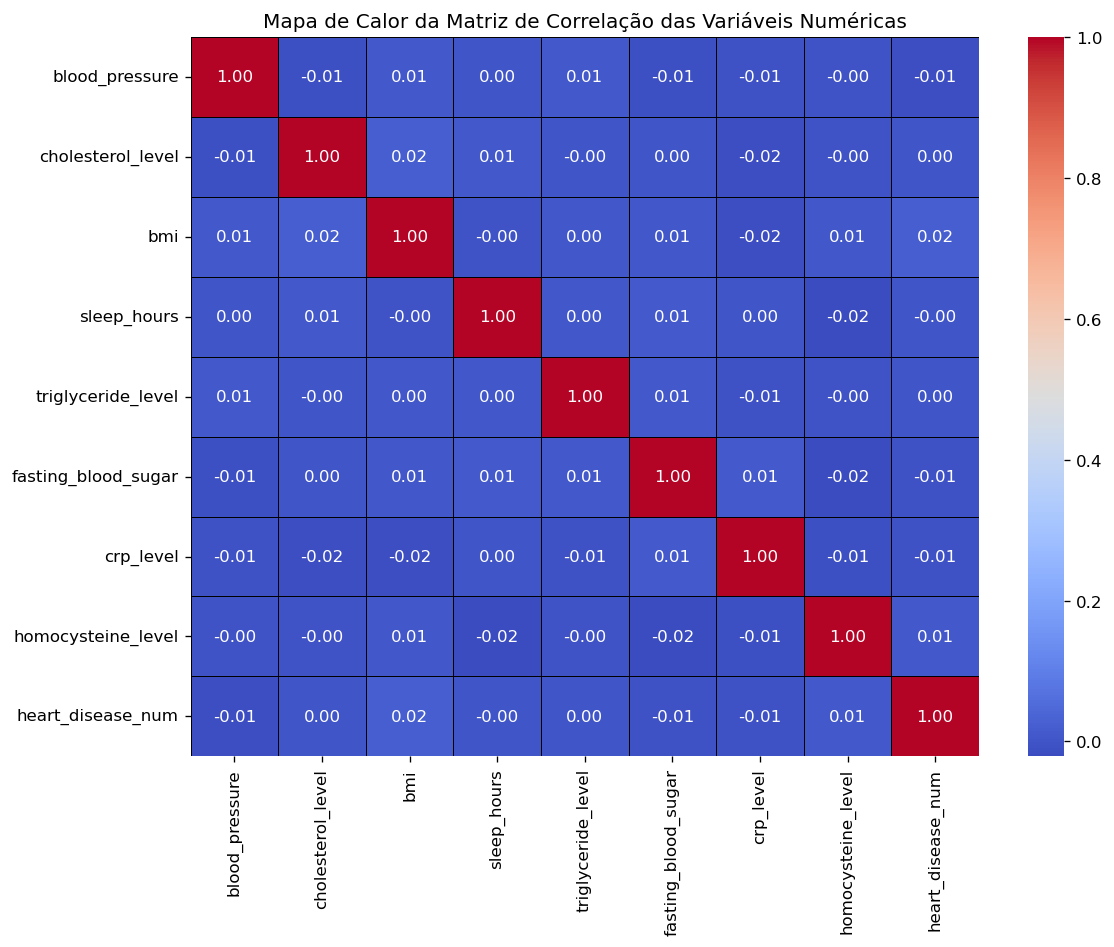

C:\Users\vasco\AppData\Local\Temp\ipykernel_33660\3281847838.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


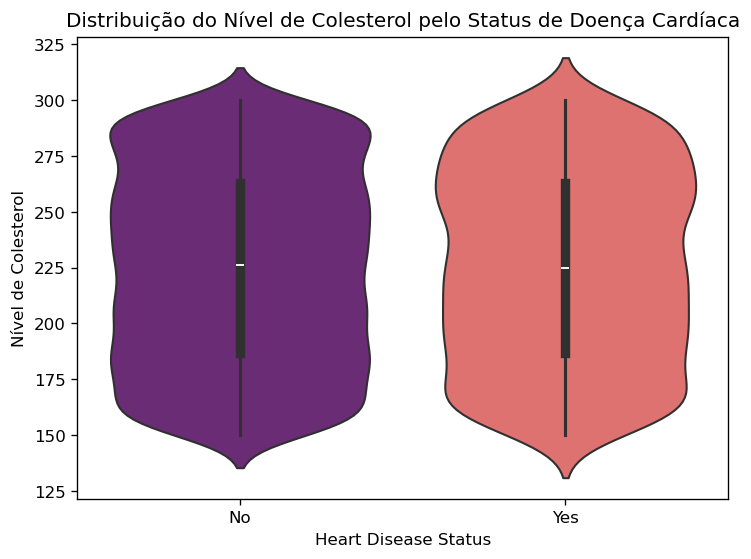

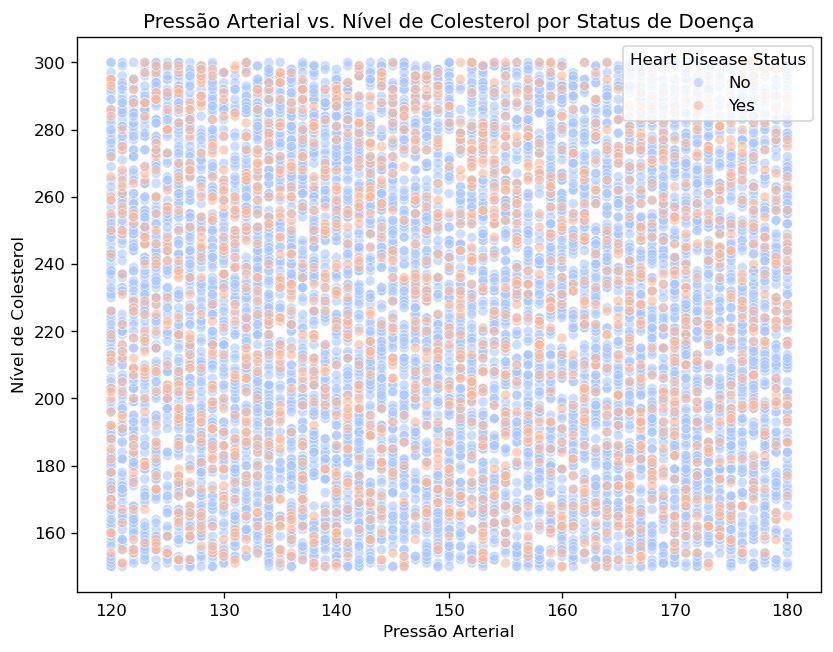

In [28]:
# 1. Risco por Grupo de Idade

bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['0-20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

df['age_group'] = pd.cut(
    df['age'],
    bins=bins,
    labels=labels,
    right=False
)

age_status_prop = pd.crosstab(
    df['age_group'], 
    df['heart_disease_status'], 
    normalize='index'
) 

plt.figure(figsize=(8, 5))
age_status_prop.plot(kind='bar', stacked=True, colormap='Spectral', ax=plt.gca())

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Proporção de Doença Cardíaca por Grupo de Idade')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Grupos de Idade')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Heart Disease Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Distribuição da Pressão Arterial por Status da Doença
plt.figure(figsize=(7, 5))
sns.boxplot(
    hue='heart_disease_status', 
    y='blood_pressure', 
    data=df, 
    palette='viridis'
)
plt.title('Distribuição da Pressão Arterial pelo Status de Doença Cardíaca')
plt.xlabel('Heart Disease Status')
plt.ylabel('Pressão Arterial')
plt.show()

plt.figure(figsize=(9, 6))

sns.boxplot(
    # Eixo X
    x='family_heart_disease',

    # Eixo Y
    y='blood_pressure',

    #target
    hue='heart_disease_status',

    data=df,
    palette='Accent',    
    linewidth=1.5
)

plt.title('Pressão Arterial pela Interação de Histórico Familiar e Status da Doença')
plt.xlabel('Histórico Familiar de Doença Cardíaca')
plt.ylabel('Pressão Arterial')
plt.legend(title='Heart Disease Status', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 3. Mapa de Calor de Correlação
correlation_matrix = df[numeric_cols_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,     # Mostrar os valores de correlação na célula
    cmap='coolwarm', # Escolhe um mapa de cores divergente (bom para correlação)
    fmt=".2f",      # Formato de duas casas decimais
    linewidths=.5,  # Linhas entre as células
    linecolor='black'
)
plt.title('Mapa de Calor da Matriz de Correlação das Variáveis Numéricas')
plt.tight_layout()
plt.show()

#4 Gráfico KDE - Distribuição de Colesterol
plt.figure(figsize=(7, 5))
sns.violinplot(
    x='heart_disease_status',
    y='cholesterol_level',
    data=df,
    palette='magma' # Paleta de cores diferente para distinção
)
plt.title('Distribuição do Nível de Colesterol pelo Status de Doença Cardíaca')
plt.xlabel('Heart Disease Status')
plt.ylabel('Nível de Colesterol')
plt.show()

# Colesterol vs. Pressão Arterial
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='blood_pressure',
    y='cholesterol_level',
    hue='heart_disease_status',
    data=df,
    palette='coolwarm',
    alpha=0.6 # Para lidar com a sobreposição de pontos
)
plt.title('Pressão Arterial vs. Nível de Colesterol por Status de Doença')
plt.xlabel('Pressão Arterial')
plt.ylabel('Nível de Colesterol')
plt.legend(title='Heart Disease Status')
plt.show()

### Análise de Proporção em Variáveis Categóricas Chave

O objetivo é descobrir se alguma categoria específica tem uma proporção de Doença Cardíaca (Yes) significativamente maior que o risco base ($\sim 20\%$ da amostra).


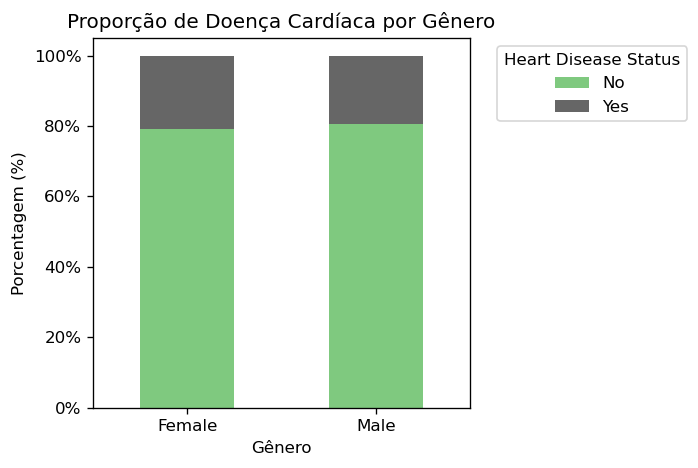

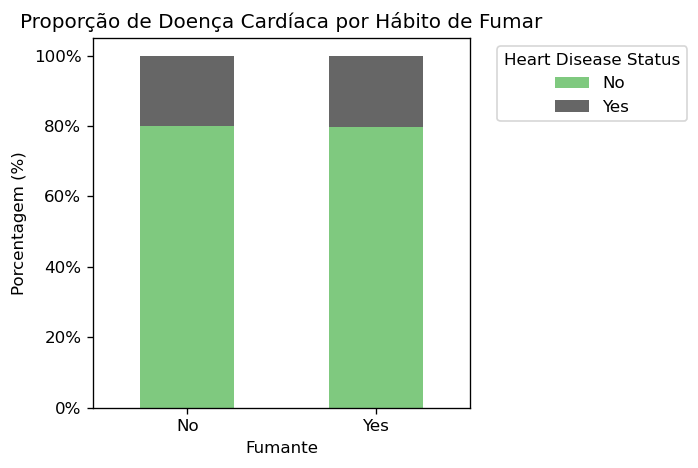

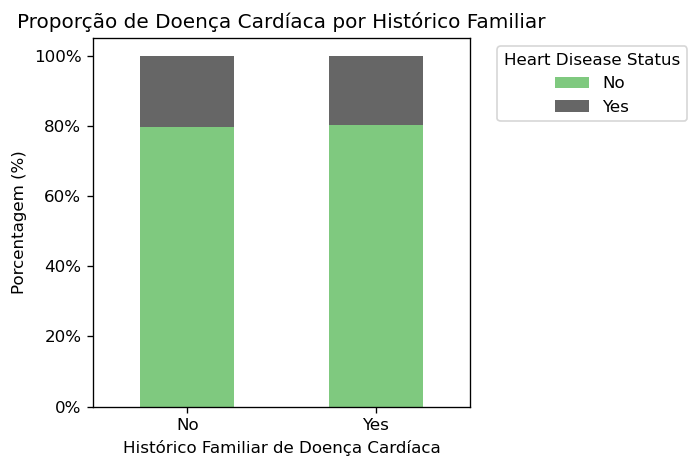

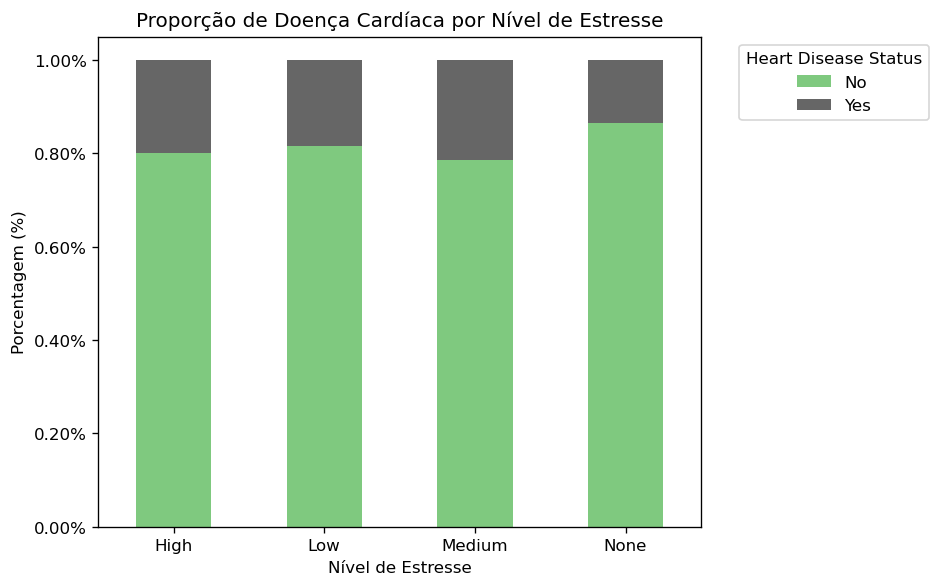

,age,gender,blood_pressure,cholesterol_level,exercise_habits,smoking,family_heart_disease,diabetes,bmi,high_blood_pressure,...,stress_level,sleep_hours,sugar_consumption,triglyceride_level,fasting_blood_sugar,crp_level,homocysteine_level,heart_disease_status,heart_disease_num,age_group
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No,0,60-69
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No,0,40-49
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,High,5.249405,High,293.0,94.0,12.509046,5.961958,No,0,30-39
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,High,7.030971,High,263.0,154.0,10.381259,8.153887,No,0,60-69
5,25.0,Male,152.0,257.0,Low,Yes,No,No,28.144681,No,...,Medium,5.504876,Low,126.0,91.0,4.297575,10.815983,No,0,20-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,25.0,Female,136.0,243.0,Medium,Yes,No,No,18.788791,Yes,...,High,6.834954,Medium,343.0,133.0,3.588814,19.132004,Yes,1,20-29
9996,38.0,Male,172.0,154.0,Medium,No,No,No,31.856801,Yes,...,High,8.247784,Low,377.0,83.0,2.658267,9.715709,Yes,1,30-39
9997,73.0,Male,152.0,201.0,High,Yes,No,Yes,26.899911,No,...,Low,4.436762,Low,248.0,88.0,4.408867,9.492429,Yes,1,70+
9998,23.0,Male,142.0,299.0,Low,Yes,No,Yes,34.964026,Yes,...,High,8.526329,Medium,113.0,153.0,7.215634,11.873486,Yes,1,20-29


In [30]:
gender_status_prop = pd.crosstab(
    df['gender'],
    df['heart_disease_status'],
    normalize='index'
) * 100

plt.figure(figsize=(6, 4))
gender_status_prop.plot(kind='bar', stacked=True, colormap='Accent', ax=plt.gca())

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Proporção de Doença Cardíaca por Gênero')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Gênero')
plt.xticks(rotation=0)
plt.legend(title='Heart Disease Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

smoking_status_prop = pd.crosstab(
    df['smoking'],
    df['heart_disease_status'],
    normalize='index'
) * 100


plt.figure(figsize=(6, 4))
smoking_status_prop.plot(kind='bar', stacked=True, colormap='Accent', ax=plt.gca())

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Proporção de Doença Cardíaca por Hábito de Fumar')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Fumante')
plt.xticks(rotation=0)
plt.legend(title='Heart Disease Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


family_status_prop = pd.crosstab(
    df['family_heart_disease'],
    df['heart_disease_status'],
    normalize='index'
) * 100

plt.figure(figsize=(6, 4))
family_status_prop.plot(kind='bar', stacked=True, colormap='Accent', ax=plt.gca())

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Proporção de Doença Cardíaca por Histórico Familiar')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Histórico Familiar de Doença Cardíaca')
plt.xticks(rotation=0)
plt.legend(title='Heart Disease Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


stress_status_prop = pd.crosstab(
    df['stress_level'],
    df['heart_disease_status'],
    normalize='index'
)

# 2. Plotagem
plt.figure(figsize=(8, 5))
stress_status_prop.plot(kind='bar', stacked=True, colormap='Accent', ax=plt.gca())

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Proporção de Doença Cardíaca por Nível de Estresse')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Nível de Estresse')
plt.xticks(rotation=0)
plt.legend(title='Heart Disease Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

display(df)

### Interpetação dos Graficos

Os resultados representados são os espectados uma vez que a correlação linear próxima de zero - dado pelo mapa de calor e regressão linear - é a prova estatística de que modelos que assumem uma relação regressão linear ou logística simples serão ineficazes.

O Gráfico de Barras mostra que, independentemente do grupo de idade, a prevalência de doença cardíaca neste conjunto de dados é consistentemente alta, indicando que a idade por si só (como um único fator contínuo) não é o único motor linear da doença, mas sim um forte fator de risco quando categorizada.

É possível verificar a idade é um forte preditor de pertencer a um grupo de alto risco, mas a forma como a doença se manifesta não é linear no nosso conjunto de dados (todos os grupos têm a mesma prevalência alta).

>A baixa correlação linear é um facto estatístico neste conjunto de dados, mas não implica total independência na realidade clínica. Significa apenas que um modelo de regressão linear simples não seria eficaz.


#### Conclusão

O principal desafio encontrado nesta análise é que os fatores de risco tradicionais (Idade, Pressão Arterial, Colesterol, etc.) não estão a demonstrar o poder preditivo esperado de forma isolada e linear. A análise mostra consistentemente que o problema não reside nas correlações lineares nem nas relações de proporção simples com as variáveis categóricas mais óbvias.

Assim após a análise exploratória dos dados é possivel concluir que podemos descartar as relações lineares e isoladas. Usar modelos de Machine Learning não-lineares (como Random Forests ou Redes Neurais) para capturar a complexa interação entre os fatores.


***

## Regras de Associação à Priori


De forma a percebemos qual antecedente, X implica um consequente, Y devemos determinar as métricas para usar num algoritmo à priori, onde a frequência onde X e Y aparecem juntos no conjunto de total de transações. Devemos também ter em conta a **confiança**, ou seja a probabilidade de um consquente estar associado ao antecedente. 


In [32]:
list_of_apriori_cols = [
    "age",
    "gender",
    "blood_pressure",
    "cholesterol_level",
    "exercise_habits",
    "smoking",
    "family_heart_disease",
    "diabetes",
    "bmi",
    "high_blood_pressure",
    "high_ldl_cholesterol",
    "alcohol_consumption",
    "stress_level",
    "sleep_hours",
    "sugar_consumption",
    "triglyceride_level",
    "fasting_blood_sugar",
    "crp_level",
    "homocysteine_level",
    "heart_disease_status"
]

# Criar cópia para não afetar o DataFrame original
df_apriori = df[list_of_apriori_cols].copy()

# 1. DISCRETIZAR VARIÁVEIS NUMÉRICAS CONTÍNUAS
# Age (já tem age_group, mas vou refazer aqui)
df_apriori['age_cat'] = pd.cut(
    df_apriori['age'], 
    bins=[0, 30, 45, 60, 100], 
    labels=['Jovem', 'Adulto', 'Meia-idade', 'Idoso']
)

# Blood Pressure
df_apriori['bp_cat'] = pd.cut(
    df_apriori['blood_pressure'],
    bins=[0, 120, 140, 200],
    labels=['Normal', 'Elevada', 'Alta']
)

# Cholesterol
df_apriori['chol_cat'] = pd.cut(
    df_apriori['cholesterol_level'],
    bins=[0, 200, 240, 500],
    labels=['Desejável', 'Limítrofe', 'Alto']
)

# BMI
df_apriori['bmi_cat'] = pd.cut(
    df_apriori['bmi'],
    bins=[0, 18.5, 25, 30, 50],
    labels=['Baixo_Peso', 'Normal', 'Sobrepeso', 'Obeso']
)

# Sleep Hours
df_apriori['sleep_cat'] = pd.cut(
    df_apriori['sleep_hours'],
    bins=[0, 6, 8, 12],
    labels=['Pouco', 'Adequado', 'Muito']
)

# Triglycerides
df_apriori['trig_cat'] = pd.cut(
    df_apriori['triglyceride_level'],
    bins=[0, 150, 200, 1000],
    labels=['Normal', 'Limítrofe', 'Alto']
)

# Fasting Blood Sugar
df_apriori['fbs_cat'] = pd.cut(
    df_apriori['fasting_blood_sugar'],
    bins=[0, 100, 126, 300],
    labels=['Normal', 'Pré-diabetes', 'Diabetes']
)

# CRP Level
df_apriori['crp_cat'] = pd.cut(
    df_apriori['crp_level'],
    bins=[0, 1, 3, 100],
    labels=['Baixo', 'Moderado', 'Alto']
)

# Homocysteine
df_apriori['hcy_cat'] = pd.cut(
    df_apriori['homocysteine_level'],
    bins=[0, 10, 15, 100],
    labels=['Normal', 'Moderado', 'Alto']
)

categorical_cols = [
    'age_cat', 'gender', 'bp_cat', 'chol_cat', 'exercise_habits',
    'smoking', 'family_heart_disease', 'diabetes', 'bmi_cat',
    'high_blood_pressure', 'high_ldl_cholesterol', 'alcohol_consumption',
    'stress_level', 'sleep_cat', 'sugar_consumption', 'trig_cat',
    'fbs_cat', 'crp_cat', 'hcy_cat', 'heart_disease_status'
]

# 3. ONE-HOT ENCODING
df_apriori_ready = pd.get_dummies(
    df_apriori[categorical_cols], 
    drop_first=False,  # Manter todas as categorias
    prefix_sep='='
)
df_apriori_ready = df_apriori_ready.astype(bool)

print(f"Número de colunas após discretização: {df_apriori_ready.shape[1]}")

Número de colunas após discretização: 59


In [34]:
freq_items = apriori(
    df_apriori_ready, 
    min_support=0.05,
    use_colnames=True,
    max_len=4
)

# Gerar regras
rules = association_rules(
    freq_items, 
    metric='confidence', 
    min_threshold=0.7 
)

print("Regras antes do filtro")
display(rules)

# Filtrar regras relevantes
rules_hd = rules[
    rules['consequents'].apply(lambda x: 'heart_disease_status=Yes' in str(x))
].sort_values('lift', ascending=False)


print("\n\nRegras depois da filtragem")
display(rules_hd[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Regras antes do filtro


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(age_cat=Jovem),(crp_cat=Alto),0.199500,0.794464,0.156624,0.785081,0.988190,1.0,-0.001872,0.956343,-0.014710,0.187049,-0.045650,0.491113
1,(age_cat=Jovem),(heart_disease_status=No),0.199500,0.799771,0.160995,0.806990,1.009026,1.0,0.001440,1.037402,0.011175,0.192055,0.036054,0.504146
2,(age_cat=Adulto),(crp_cat=Alto),0.243730,0.794464,0.191383,0.785226,0.988373,1.0,-0.002251,0.956991,-0.015317,0.226005,-0.044942,0.513061
3,(age_cat=Adulto),(heart_disease_status=No),0.243730,0.799771,0.190551,0.781810,0.977543,1.0,-0.004378,0.917683,-0.029481,0.223402,-0.089700,0.510033
4,(age_cat=Meia-idade),(crp_cat=Alto),0.229472,0.794464,0.183370,0.799093,1.005827,1.0,0.001062,1.023043,0.007519,0.218150,0.022524,0.514951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12083,"(hcy_cat=Normal, fbs_cat=Diabetes, heart_disea...",(crp_cat=Alto),0.116870,0.794464,0.093662,0.801425,1.008762,1.0,0.000814,1.035056,0.009836,0.114548,0.033869,0.459659
12084,"(hcy_cat=Moderado, fbs_cat=Diabetes, crp_cat=A...",(heart_disease_status=No),0.119784,0.799771,0.097305,0.812337,1.015712,1.0,0.001505,1.066961,0.017574,0.118339,0.062758,0.467001
12085,"(hcy_cat=Moderado, fbs_cat=Diabetes, heart_dis...",(crp_cat=Alto),0.118118,0.794464,0.097305,0.823789,1.036912,1.0,0.003464,1.166420,0.040366,0.119352,0.142676,0.473133
12086,"(fbs_cat=Diabetes, hcy_cat=Alto, crp_cat=Alto)",(heart_disease_status=No),0.103757,0.799771,0.083567,0.805416,1.007059,1.0,0.000586,1.029012,0.007820,0.101916,0.028194,0.454953




Regras depois da filtragem


,antecedents,consequents,support,confidence,lift


### Conclusão das Regras de Associação

No teu dataset, não existe nenhum conjunto simples de fatores (antecedentes) cuja ocorrência aumente significativamente a probabilidade de “heart_disease = Yes” (consequente) ao nível mínimo exigido pelos algoritmos de associação

Estes resultados juntando aos resultados do EDA, reforça a necessidade de usar:

- Random Forest

- XGBoost

- Modelos não lineares

- SHAP para interpretar relações complexas

>Como as regras de associação Apriori indicaram não linearidade iremos optar pelas **Decison Rules** . 
>Estas regras, não dependem de suporte, confiança e capturam não linearidade. geram regras interpretáveis mesmo quando Apriori falha.

### One-Hot Enconding & Ordinal Enconding

Devido ao teor da pesquisa é importante usar Ordinal Enconding para variáveis que possuem uma escala real, como 
`alcohol_consumption`, `stress_level`, `sugar_consumption`, `exercise_habits` pela ordem: ['None', 'Low', 'Medium', 'High']

Para as restante variáveis não numéricas usamos One-Hot Enconding para obter uma valor binário

In [38]:
target_col = 'heart_disease_status'

cols_to_remove = [target_col, 'heart_disease_num']
df_X = df.drop(columns=cols_to_remove)
df_Y = df[target_col]

ordinal_cols = ["alcohol_consumption", "stress_level", "sugar_consumption", "exercise_habits"]
order = [['None', 'Low', 'Medium', 'High']] * len(ordinal_cols)

encoder = OrdinalEncoder(categories=order)
df_X[ordinal_cols] = encoder.fit_transform(df_X[ordinal_cols])

df_X = pd.get_dummies(df_X, drop_first=False)

display(df_X.head())
display(df_Y.head())

,age,blood_pressure,cholesterol_level,exercise_habits,bmi,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,...,low_hdl_cholesterol_Yes,high_ldl_cholesterol_No,high_ldl_cholesterol_Yes,age_group_0-20,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
1,69.0,146.0,286.0,3.0,25.221799,2.0,3.0,8.744034,2.0,133.0,...,True,True,False,False,False,False,False,False,True,False
2,46.0,126.0,216.0,1.0,29.855447,1.0,1.0,4.440440,1.0,393.0,...,True,False,True,False,False,False,True,False,False,False
3,32.0,122.0,293.0,3.0,24.130477,1.0,3.0,5.249405,3.0,293.0,...,False,False,True,False,False,True,False,False,False,False
4,60.0,166.0,242.0,1.0,20.486289,1.0,3.0,7.030971,3.0,263.0,...,False,True,False,False,False,False,False,False,True,False
5,25.0,152.0,257.0,1.0,28.144681,1.0,2.0,5.504876,1.0,126.0,...,False,True,False,False,True,False,False,False,False,False


1    No
2    No
3    No
4    No
5    No
Name: heart_disease_status, dtype: object

## Decison Rules

In [40]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=50, random_state=42)
clf.fit(df_X, df_Y)

# Ver as regras
rules = export_text(clf, feature_names= df_X.columns.tolist())
print(rules)

# Ver importância das features
feature_importance = pd.DataFrame({
    'feature': df_X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features mais importantes:")
print(feature_importance.head(10))

|--- bmi <= 26.89
|   |--- crp_level <= 7.37
|   |   |--- crp_level <= 7.36
|   |   |   |--- crp_level <= 1.11
|   |   |   |   |--- gender_Male <= 0.50
|   |   |   |   |   |--- class: No
|   |   |   |   |--- gender_Male >  0.50
|   |   |   |   |   |--- class: No
|   |   |   |--- crp_level >  1.11
|   |   |   |   |--- crp_level <= 1.12
|   |   |   |   |   |--- class: Yes
|   |   |   |   |--- crp_level >  1.12
|   |   |   |   |   |--- class: No
|   |   |--- crp_level >  7.36
|   |   |   |--- class: Yes
|   |--- crp_level >  7.37
|   |   |--- bmi <= 18.03
|   |   |   |--- class: No
|   |   |--- bmi >  18.03
|   |   |   |--- age_group_20-29 <= 0.50
|   |   |   |   |--- age <= 35.50
|   |   |   |   |   |--- class: No
|   |   |   |   |--- age >  35.50
|   |   |   |   |   |--- class: No
|   |   |   |--- age_group_20-29 >  0.50
|   |   |   |   |--- bmi <= 26.77
|   |   |   |   |   |--- class: No
|   |   |   |   |--- bmi >  26.77
|   |   |   |   |   |--- class: Yes
|--- bmi >  26.89
|   |--- bm

#### Interpretação

`Primeria Divisão`: **bmi** e **crp_level**, são as duas variáveis são as mais importantes na raiz para prever a doença cardíaca no seu dataset.

****

## K-Means

Tenta agrupar os dados em k clusters minimizando a distância Euclidiana ao centroide do cluster. Como os dados têm relações não lineares complexas, o K-Means pode não separar bem os grupos, formando um anel concênctrico

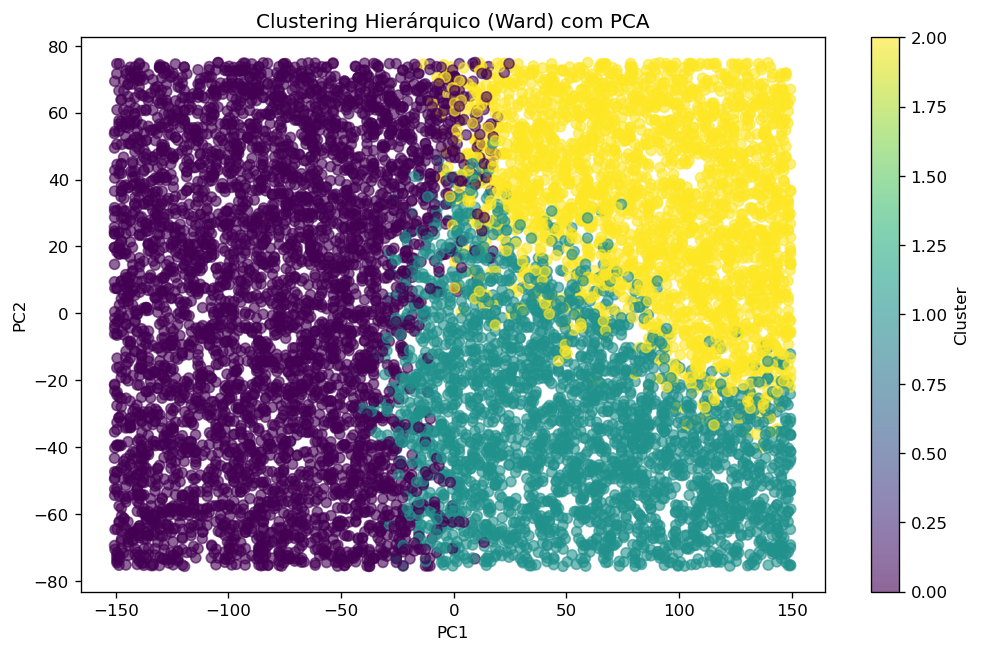

In [46]:
pca = PCA(n_components=2)
pc = pca.fit_transform(df_X)

hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hc = hc.fit_predict(df_X)

plt.figure(figsize=(10, 6))
plt.scatter(pc[:, 0], pc[:, 1], c=labels_hc, cmap='viridis', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Hierárquico (Ward) com PCA')
plt.colorbar(label='Cluster')
plt.show()

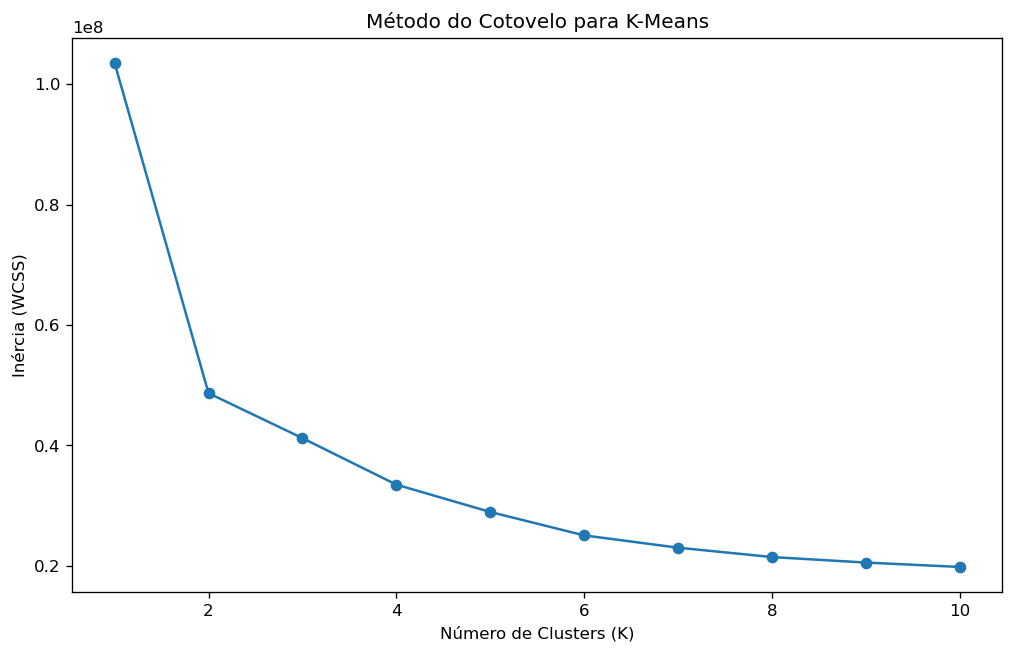

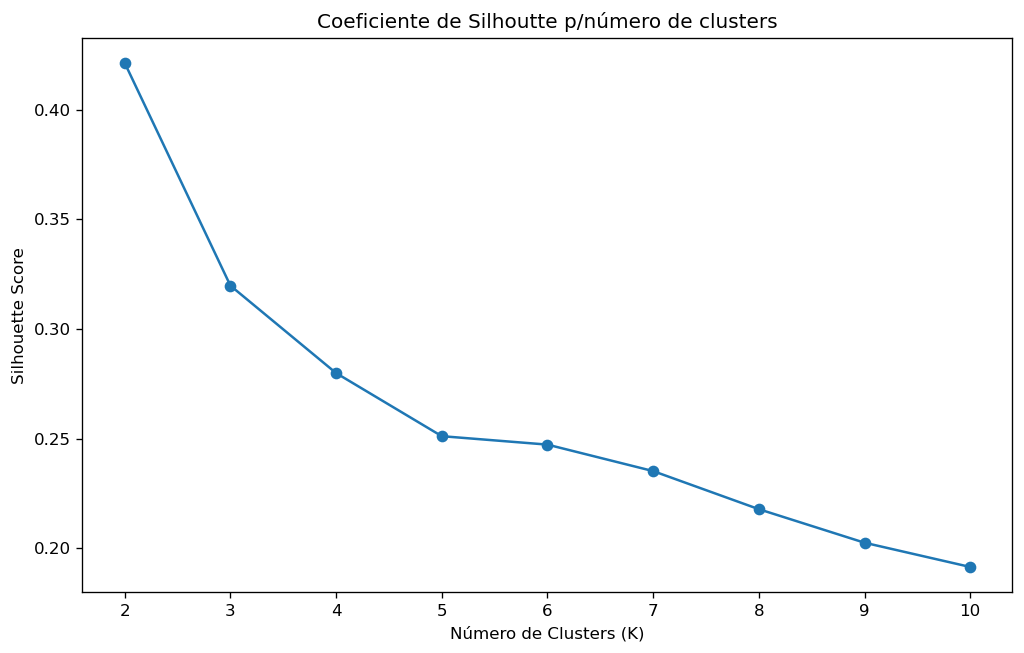

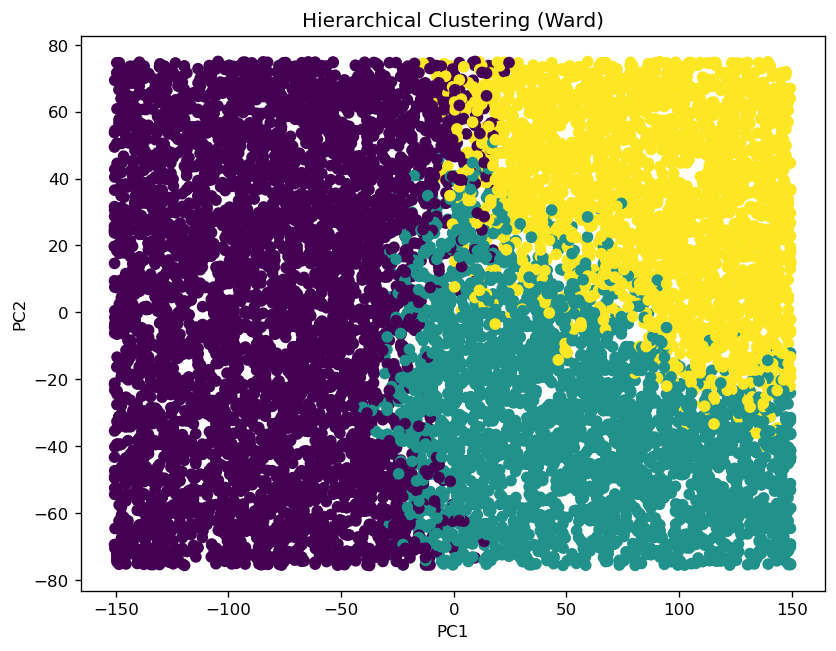

In [48]:

inertia = []
silhouette = []

# k de 1 a 10
K_range_inertia = range(1, 11)
K_range_silhouette = range(2, 11)

for k in K_range_inertia:
    kmeans = KMeans(n_clusters = k, random_state=42, n_init='auto') 
    kmeans.fit(df_X)
    
    inertia.append(kmeans.inertia_)

for k in K_range_silhouette:
    kmeans = KMeans(n_clusters = k, random_state=42, n_init='auto') 
    kmeans.fit(df_X)
    
    score = silhouette_score(df_X, kmeans.labels_)
    silhouette.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K_range_inertia, inertia, marker='o')
plt.title('Método do Cotovelo para K-Means')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette, marker='o')
plt.title('Coeficiente de Silhoutte p/número de clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(pc[:,0], pc[:,1], c = labels_hc)
plt.title("Hierarchical Clustering (Ward)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


#Z = linkage(df_X, method='ward')

#plt.figure(figsize=(12, 6))
#dendrogram(Z)
#plt.title("Dendrograma - Método Ward")
#plt.xlabel("Amostras")
#plt.ylabel("Distância")
#plt.show()

In [53]:
df_scaled = df_X.copy()
bool_cols = df_scaled.select_dtypes('bool').columns
df_scaled[bool_cols] = df_scaled[bool_cols].astype(int)

# Standardize data
scaler = StandardScaler()
df_scaled[df_scaled.columns] = scaler.fit_transform(df_scaled)

# Create and fit KMeans
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_model.fit(df_scaled)

# Assign clusters
df['Cluster'] = kmeans_model.labels_

print("Data Frame Normalizado")
display(df_scaled)

Data Frame Normalizado


,age,blood_pressure,cholesterol_level,exercise_habits,bmi,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,...,low_hdl_cholesterol_Yes,high_ldl_cholesterol_No,high_ldl_cholesterol_Yes,age_group_0-20,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
1,1.082262,-0.216148,1.391555,1.210737,-0.609941,0.469291,1.232857,1.001228,0.014851,-1.349035,...,0.996779,0.987280,-0.987280,-0.178279,-0.424814,-0.438725,-0.435178,-0.42686,2.302387,-0.473038
2,-0.180928,-1.354838,-0.214074,-1.222894,0.126035,-0.424725,-1.212751,-1.454512,-1.194461,1.635431,...,0.996779,-1.012883,1.012883,-0.178279,-0.424814,-0.438725,2.297910,-0.42686,-0.434332,-0.473038
3,-0.949826,-1.582576,1.552118,1.210737,-0.783279,-0.424725,1.232857,-0.992896,1.224162,0.487559,...,-1.003231,-1.012883,1.012883,-0.178279,-0.424814,2.279333,-0.435178,-0.42686,-0.434332,-0.473038
4,0.587971,0.922541,0.382302,-1.222894,-1.362096,-0.424725,1.232857,0.023711,1.224162,0.143198,...,-1.003231,0.987280,-0.987280,-0.178279,-0.424814,-0.438725,-0.435178,-0.42686,2.302387,-0.473038
5,-1.334275,0.125459,0.726366,-1.222894,-0.145691,-0.424725,0.010053,-0.847118,-1.194461,-1.429386,...,-1.003231,0.987280,-0.987280,-0.178279,2.353972,-0.438725,-0.435178,-0.42686,-0.434332,-0.473038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.334275,-0.785493,0.405240,-0.006078,-1.631714,0.469291,1.232857,-0.088141,0.014851,1.061495,...,-1.003231,-1.012883,1.012883,-0.178279,2.353972,-0.438725,-0.435178,-0.42686,-0.434332,-0.473038
9996,-0.620298,1.264148,-1.636203,-0.006078,0.443916,-1.318742,1.232857,0.718056,-1.194461,1.451772,...,-1.003231,-1.012883,1.012883,-0.178279,-0.424814,2.279333,-0.435178,-0.42686,-0.434332,-0.473038
9997,1.301948,0.125459,-0.558138,1.210737,-0.343402,-1.318742,-1.212751,-1.456611,-1.194461,-0.028983,...,0.996779,-1.012883,1.012883,-0.178279,-0.424814,-0.438725,-0.435178,-0.42686,-0.434332,2.113997
9998,-1.444118,-0.443886,1.689744,-1.222894,0.937445,0.469291,1.232857,0.877000,0.014851,-1.578610,...,-1.003231,-1.012883,1.012883,-0.178279,2.353972,-0.438725,-0.435178,-0.42686,-0.434332,-0.473038


## Treinamento do Modelo

In [57]:
X = df_X  
df_Y = df_Y.map({'No': 0, 'Yes': 1})
y = df_Y

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print(f"Número de Features (X): {X.shape[1]}")
print(f"Número de Observações (y): {y.shape[0]}")
print("-" * 30)
print(f"X_train (Treino): {X_train.shape}")
print(f"X_test (Teste):   {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")
print("-" * 30)

# ============ TREINAMENTO DOS MODELOS ============
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=50000),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False)
}

results = {}
print('\nInicio do Treinamento\n')

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    conf_mat = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'Accuracy': acc,
        'Confusion Matrix': conf_mat,
        'Classification Report': class_report,
        'Model': model  # Guardar modelo treinado
    }
    
    print(f"✅ {name:<25} Concluído. Accuracy: {acc:.4f}")

print("\n" + "="*50)

Número de Features (X): 34
Número de Observações (y): 9609
------------------------------
X_train (Treino): (6726, 34)
X_test (Teste):   (2883, 34)
y_train: (6726,)
y_test:  (2883,)
------------------------------

Inicio do Treinamento

✅ Decision Tree             Concluído. Accuracy: 0.6746
✅ Random Forest             Concluído. Accuracy: 0.7999
✅ Logistic Regression       Concluído. Accuracy: 0.7999


C:\Users\vasco\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:32:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost                   Concluído. Accuracy: 0.7752
✅ CatBoost                  Concluído. Accuracy: 0.7995

